In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import skew, kurtosis
from sklearn.neighbors import LocalOutlierFactor

In [3]:
gps_data = pd.read_csv('gps_gyro_data/Walking_GPS_2025_06_04_19_35_39.csv')

In [4]:
gps_data.head()

,Time (s),Latitude (°),Longitude (°),Altitude (m),Altitude WGS84 (m),Speed (m/s),Direction (°),Distance (km),Horizontal Accuracy (m),Vertical Accuracy (m),Satellites
0,0.143797,52.167857,4.503114,5.210720,48.368458,1.06,279.492188,0.001789,7.926995,4.0,-1
1,1.143812,52.167863,4.503090,6.649868,49.807612,1.06,271.757812,0.006861,6.419400,4.0,-1
2,2.143828,52.167905,4.503118,6.126186,49.283859,0.82,272.109375,0.009395,5.508326,4.0,-1
3,3.143843,52.167920,4.503145,6.135403,49.293040,0.58,272.460938,0.009739,5.404943,4.0,-1
4,4.141159,52.167917,4.503144,6.480556,49.638198,0.80,272.460938,0.011070,4.846990,4.0,-1


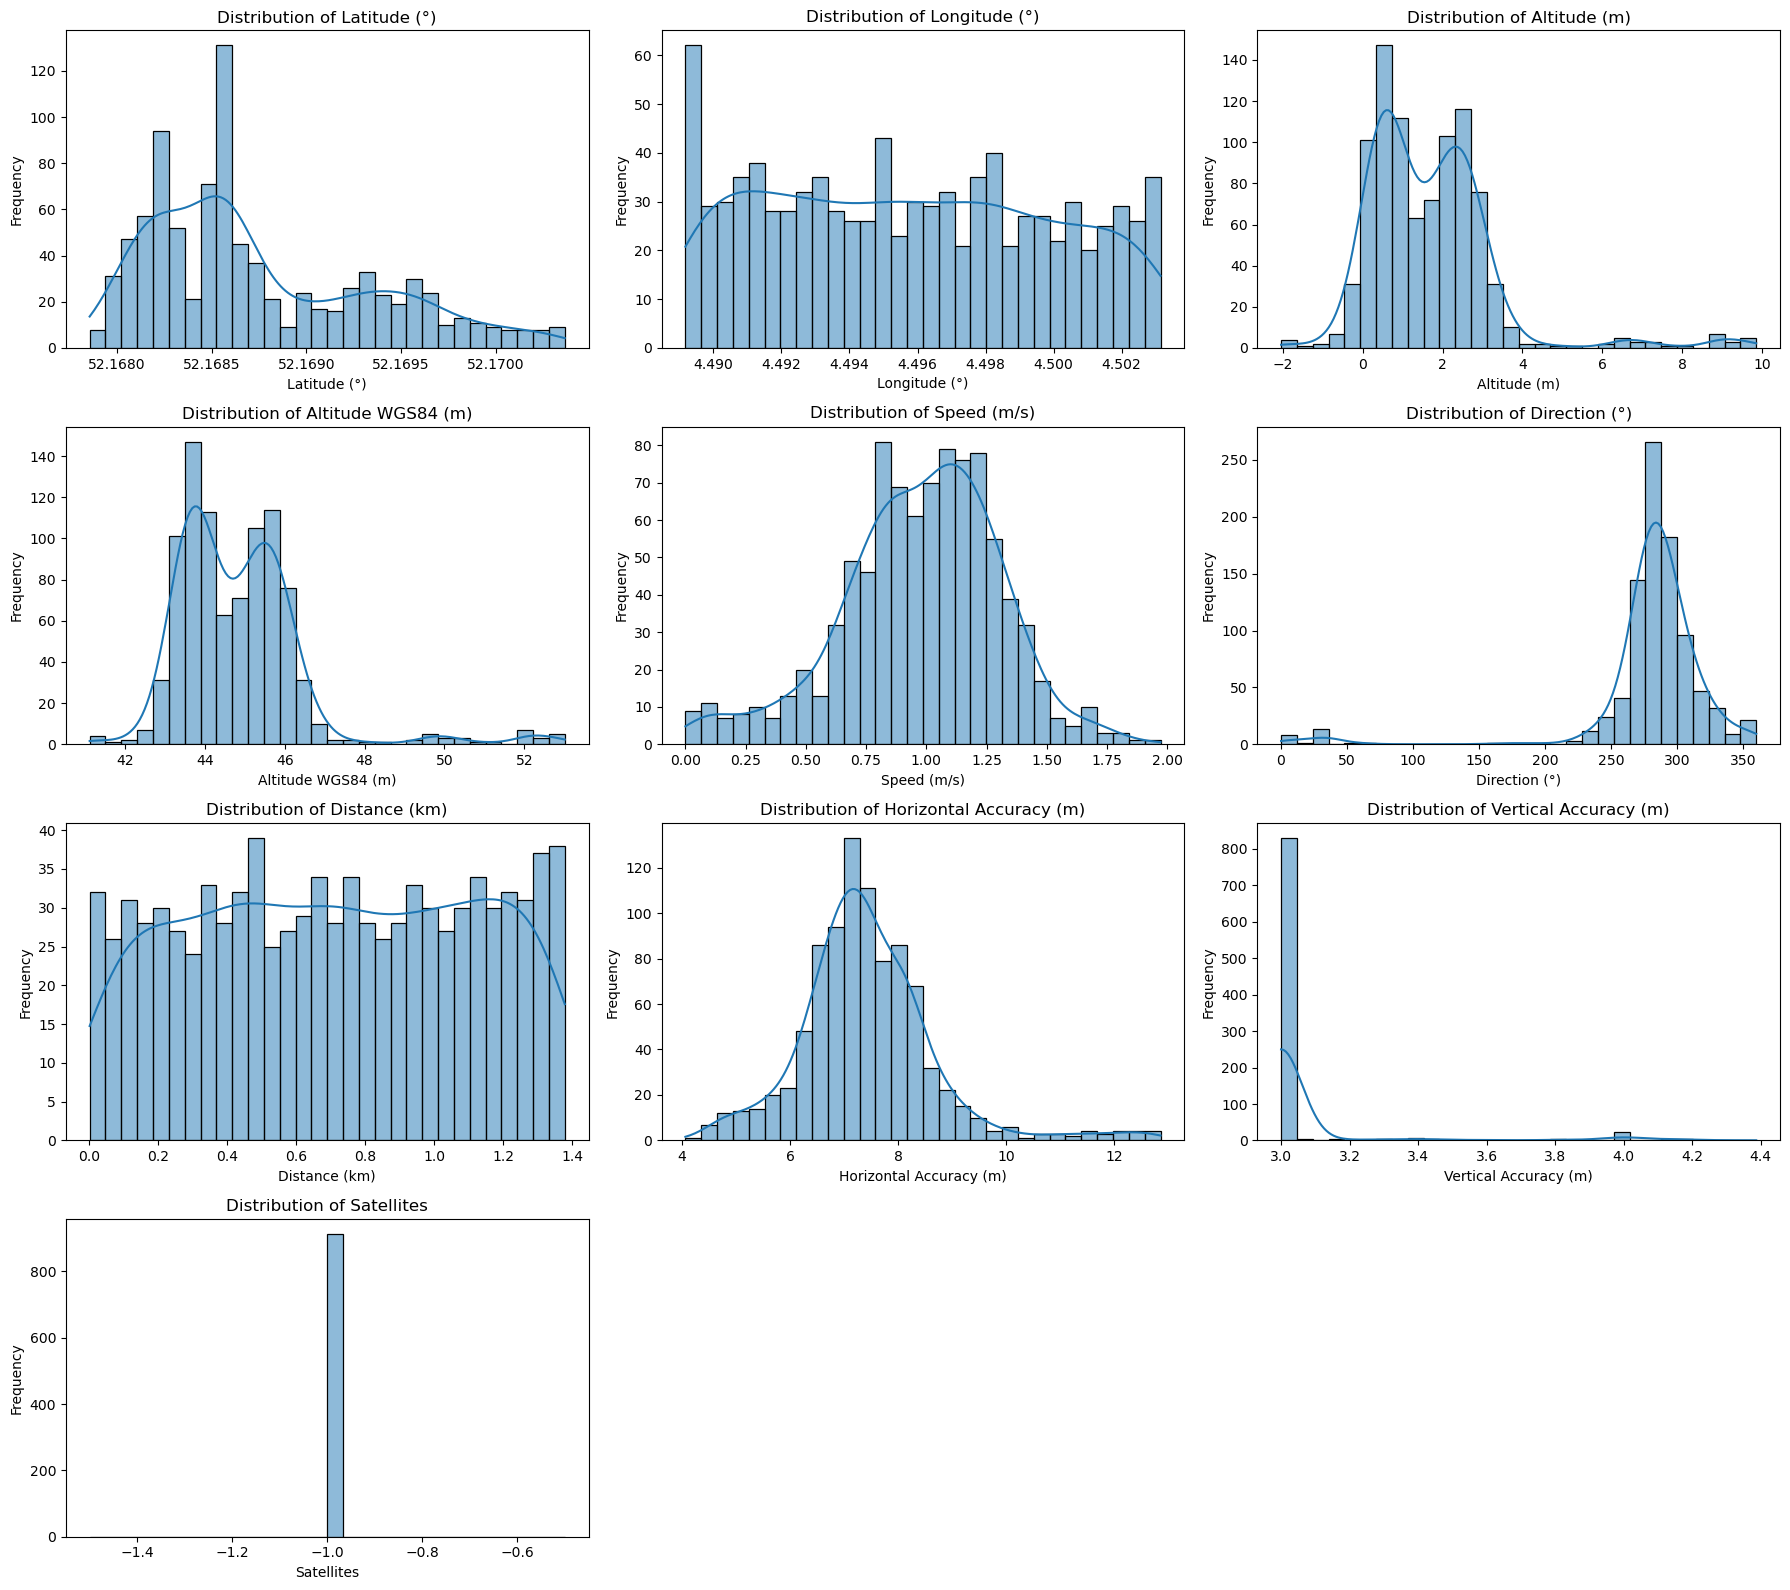

In [5]:
# Drop the 'Time (s)' column for this purpose
gps_data_copy = gps_data.copy()
features_to_plot = gps_data_copy.columns.drop("Time (s)")

# Determine grid size
num_features = len(features_to_plot)
cols = 3
rows = (num_features + cols - 1) // cols  # round up division

# Create figure and axes
plt.figure(figsize=(6 * cols, 4 * rows))

for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(gps_data[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [6]:
# Use only the 'Speed (m/s)' feature
X_speed = gps_data[["Speed (m/s)"]]

# Mask for non-missing values
valid_mask_speed = X_speed.notnull().squeeze()

# Prepare result containers
lof_labels_speed = pd.Series([np.nan] * len(X_speed), index=X_speed.index)
lof_scores_speed = pd.Series([np.nan] * len(X_speed), index=X_speed.index)

# Apply LOF on valid values
lof_speed = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
X_valid_speed = X_speed[valid_mask_speed]
lof_result_speed = lof_speed.fit_predict(X_valid_speed)
lof_score_result_speed = lof_speed.negative_outlier_factor_

# Assign back to full DataFrame
lof_labels_speed[valid_mask_speed] = lof_result_speed
lof_scores_speed[valid_mask_speed] = lof_score_result_speed

# Add to original DataFrame
gps_data["LOF_Score_Speed"] = lof_scores_speed
gps_data["Outlier_Speed"] = lof_labels_speed

In [7]:
# Choose the features to use
features = ["Speed (m/s)", "Direction (°)"]
X = gps_data[features].copy()

# Identify rows with no missing values in the selected features
valid_mask = X.notnull().all(axis=1)

# Prepare storage for results
lof_labels = pd.Series([np.nan] * len(X), index=X.index)
lof_scores = pd.Series([np.nan] * len(X), index=X.index)

# Apply LOF only on valid rows
lof_model = LocalOutlierFactor(n_neighbors=20, contamination=0.04)
X_valid = X[valid_mask]
lof_result = lof_model.fit_predict(X_valid)
lof_score_result = lof_model.negative_outlier_factor_

# Insert results back into full DataFrame
lof_labels[valid_mask] = lof_result
lof_scores[valid_mask] = lof_score_result

# Append results to original DataFrame
gps_data["LOF_Score"] = lof_scores
gps_data["Outlier"] = lof_labels

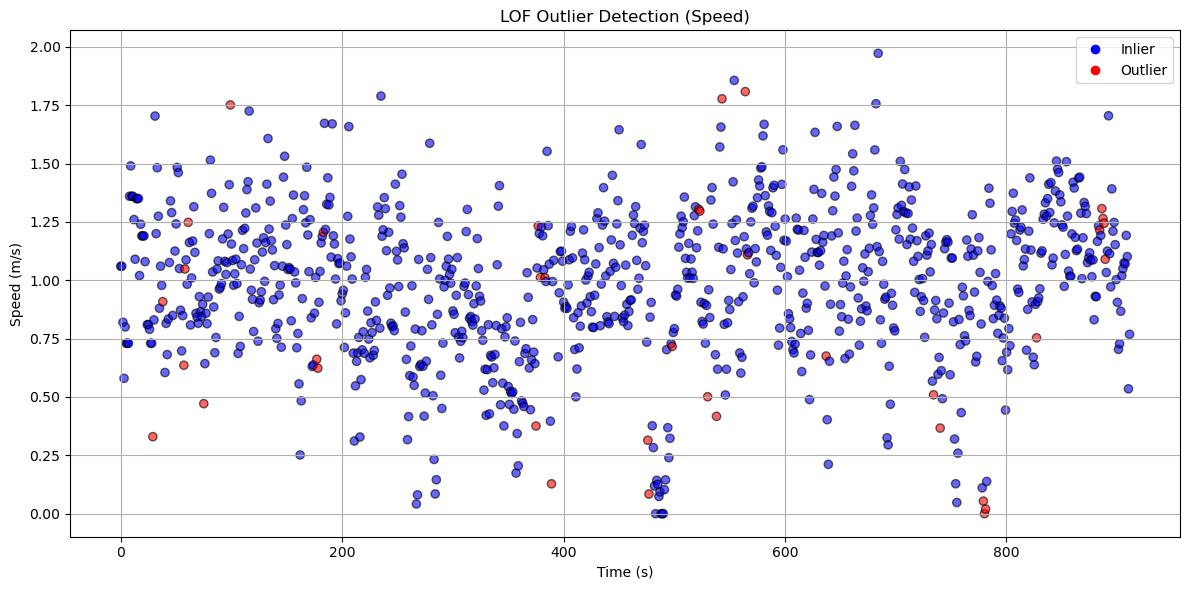

In [11]:
# Filter rows where LOF was evaluated
gps_data_plot = gps_data[gps_data["Outlier"].notna()]

# Map colors: red = outlier, blue = inlier
colors = gps_data_plot["Outlier"].map({1: "blue", -1: "red"})

# Plot speed over time with color-coded outliers
plt.figure(figsize=(12, 6))
plt.scatter(gps_data_plot["Time (s)"], gps_data_plot["Speed (m/s)"], c=colors, alpha=0.6, edgecolor='k')
plt.xlabel("Time (s)")
plt.ylabel("Speed (m/s)")
plt.title("LOF Outlier Detection (Speed)")
plt.grid(True)
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', label='Inlier', markerfacecolor='blue', markersize=8),
    plt.Line2D([0], [0], marker='o', color='w', label='Outlier', markerfacecolor='red', markersize=8)
])
plt.tight_layout()
plt.show()


In [9]:
# Select relevant features (e.g., speed and direction for GPS data)
X = gps_data[["Speed (m/s)", "Direction (°)"]].dropna()

# Fit the LOF model
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)  # adjust contamination as needed
y_pred = lof.fit_predict(X)

# -1 for outliers, 1 for inliers
X["LOF_Score"] = lof.negative_outlier_factor_
X["Outlier"] = y_pred